# 

In [26]:
import pyreadr
import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import scipy.stats as stats
from scipy.linalg import eigh
import pickle
from itertools import product

In [27]:
from fault_detection_algorithms.PCAFaultDetector import BaseFaultDetectionAlgorithm 

In [29]:
# constants
datasets_dir = "datasets"
dataset_dir = f"./{datasets_dir}/TEP/"
dataset_fast_dir = f"./{datasets_dir}/TEP_fast/"
save_fast_dataset = True 
read_fast = True 
slow_fallback = True

In [30]:
def read_r_as_df(file_path):
    result = pyreadr.read_r(file_path) # also works for Rds
    return result[list(result.keys())[0]]


In [31]:
def read_test_dataset ():
    fast_error = False
    try:
        if read_fast:
            with open(f"{dataset_fast_dir}/test_df.pickle", 'rb') as f:
                return pickle.load(f)
    except:
        fast_error = True
    if slow_fallback or fast_error:
        test_faulty_df = read_r_as_df(f"{dataset_dir}/TEP_Faulty_Testing.RData")
        test_non_falty_df = read_r_as_df(f"{dataset_dir}/TEP_FaultFree_Testing.RData")
        
        test_df = pd.concat((test_faulty_df, test_non_falty_df))
        del test_faulty_df
        del test_non_falty_df
        if save_fast_dataset:
            with open(f"{dataset_fast_dir}/test_df.pickle", 'wb') as f:
                pickle.dump(test_df, f)
            
        return test_df
    return None
        

In [32]:

test_df = read_test_dataset()

In [9]:
with open ("pca_predictor_params.pickle", "rb") as f:
    pca_predictor_params = pickle.load(f)

In [10]:
def detect_fault(new_sample):
    # Normalize the new sample
    new_sample_norm = (new_sample - pca_predictor_params["mean"]) /pca_predictor_params["std"] 

    P_res = pca_predictor_params["P_res"]
    P_pc= pca_predictor_params["P_pc"]
    J_th_SPE = pca_predictor_params['J_th_SPE']
    J_th_T2= pca_predictor_params['J_th_T2']
    eigenvalues = pca_predictor_params['eigenvalues']
    l = pca_predictor_params["l"]
    # Compute SPE
    SPE = new_sample_norm @ P_res @ P_res.T @ new_sample_norm.T

    # Compute T² statistic
    T2 = new_sample_norm @ P_pc @ np.linalg.inv(np.diag(eigenvalues[:l])) @ P_pc.T @ new_sample_norm.T

    # Fault Detection Logic
    if SPE > J_th_SPE or T2 > J_th_T2:
        return True 
    return False

In [11]:
#single prediction
detect_fault(np.array(test_df.iloc[-100, 3:]))

False

In [12]:
# fig, ax = plt.subplots(13,4,figsize=(30,50))

# cols_names = test_falty_df.columns[3:]
# for j in range(1,5):
#     df_train = test_falty_df[(test_falty_df.simulationRun==j)&(test_falty_df.faultNumber==1)].iloc[:,3:]
#     for i in range(df_train.shape[1]):
#         ax.ravel()[i].plot(range(0,960),df_train.iloc[:,i])
#         #df_train.iloc[:,i].plot(ax=ax.ravel()[i]) 
#         ax.ravel()[i].set_title(cols_names[i])
#     #print(j)

In [33]:
x_test = test_df.values[:, 3:]

In [34]:
def detect_fault_batch(samples, pca_predictor_params=pca_predictor_params, roc_plot=False):
    """
    Detect faults for multiple machine states at once using PCA-based SPE and T^2.
    
    Parameters
    ----------
    samples : np.ndarray
        Shape (m, n) or (n,) for single. (m = number of samples, n = number of features)
    pca_predictor_params : dict
        PCA model parameters, including:
            - mean, std      : arrays of shape (n,) for normalization
            - P_res, P_pc    : projection matrices for the residual and principal subspaces
            - eigenvalues    : eigenvalues in descending order
            - l              : number of principal components used
            - J_th_SPE, J_th_T2 : thresholds for SPE and T² statistics

    Returns
    -------
    np.ndarray
        Boolean array of shape (m,) indicating True (fault) or False (normal) for each sample.
    """
    
    # Unpack parameters
    mean       = pca_predictor_params["mean"]
    std        = pca_predictor_params["std"]
    P_res      = pca_predictor_params["P_res"]
    P_pc       = pca_predictor_params["P_pc"]
    l          = pca_predictor_params["l"]
    eigs       = pca_predictor_params["eigenvalues"][:l]
    J_th_SPE   = pca_predictor_params["J_th_SPE"]
    J_th_T2    = pca_predictor_params["J_th_T2"]

    # Ensure samples is 2D => shape (m, n)
    samples = np.atleast_2d(samples)

    # 1) Normalize: X_norm has shape (m, n)
    X_norm = (samples - mean) / std

    # 2) SPE = sum of squares in residual subspace
    #    residual = X_norm * P_res => (m, n-l)
    residual = X_norm @ P_res               # shape (m, n-l)
    SPE_vals = np.sum(residual**2, axis=1)  # shape (m,)

    # 3) T² statistic for each row
    #    pc_scores = X_norm * P_pc => shape (m, l)
    pc_scores = X_norm @ P_pc
    # Instead of forming (m x m) matrix, do elementwise scaled sum of squares:
    # T²_i = sum_j( pc_scores[i, j]^2 / eigs[j] )
    T2_vals = np.sum((pc_scores**2) / eigs, axis=1)  # shape (m,)

    # 4) Compare with thresholds (fault if SPE > J_th_SPE OR T² > J_th_T2)
    faults = (SPE_vals > J_th_SPE) | (T2_vals > J_th_T2)
    if roc_plot:
        plt.hist(SPE_vals,bins=100)
        plt.show()
        plt.hist(T2_vals, bins=100)
        plt.show()
    return faults


In [35]:
pca_predictor_params["J_th_SPE"]

29.672565740289073

In [36]:
pca_predictor_params["J_th_T2"]

52.19402469957485

In [37]:
# Unpack parameters
mean       = pca_predictor_params["mean"]
std        = pca_predictor_params["std"]
P_res      = pca_predictor_params["P_res"]
P_pc       = pca_predictor_params["P_pc"]
l          = pca_predictor_params["l"]
eigs       = pca_predictor_params["eigenvalues"][:l]
J_th_SPE   = pca_predictor_params["J_th_SPE"]
J_th_T2    = pca_predictor_params["J_th_T2"]

# Ensure samples is 2D => shape (m, n)
# samples = np.atleast_2d(samples)

# 1) Normalize: X_norm has shape (m, n)
X_norm = (x_test - mean) / std

# 2) SPE = sum of squares in residual subspace
#    residual = X_norm * P_res => (m, n-l)
residual = X_norm @ P_res               # shape (m, n-l)
SPE_vals = np.sum(residual**2, axis=1)  # shape (m,)

# 3) T² statistic for each row
#    pc_scores = X_norm * P_pc => shape (m, l)
pc_scores = X_norm @ P_pc
# Instead of forming (m x m) matrix, do elementwise scaled sum of squares:
# T²_i = sum_j( pc_scores[i, j]^2 / eigs[j] )
T2_vals = np.sum((pc_scores**2) / eigs, axis=1)  # shape (m,)

# 4) Compare with thresholds (fault if SPE > J_th_SPE OR T² > J_th_T2)
faults = (SPE_vals > J_th_SPE) | (T2_vals > J_th_T2)


In [38]:
expected_fault = test_df["sample"]>160
expected_fault[test_df["faultNumber"]==0] = False# non faulty test

In [19]:
def compute_error_metrics(predicted, expected):
    TP = np.sum(predicted  &  expected)
    FP = np.sum(predicted  & ~expected)
    FN = np.sum(~predicted &  expected)
    TN = np.sum(~predicted & ~expected)
    error_metrics = dict()
    error_metrics["fault_detection_rate"] = TP/(TP+FN)
    error_metrics["false_alarm_rate"] = FP/(TN+FP)
    error_metrics["false_detection_rate"]= FP/(TP+FP)
    #error_metrics["1-specificity"]=1- TN/(TN+FP)
    return error_metrics


In [20]:
fault_selector = test_df["faultNumber"]== 10
exp_fault = expected_fault[fault_selector]
SPE_vals_fault = SPE_vals[fault_selector]
T2_vals_fault = T2_vals[fault_selector]

metrics = {}
for t_spe, t_t2 in product(range(0,100,1), range(0,120,1)):
    pred_faults = (SPE_vals_fault > t_spe) | (T2_vals_fault > t_t2)
    metrics[(t_spe,t_t2)] = compute_error_metrics(pred_faults,exp_fault)


In [21]:
fault_detection_rate = []
false_alarm_rate= []
for met in metrics.values():
    fault_detection_rate.append(met["fault_detection_rate"])
    false_alarm_rate.append(met["false_alarm_rate"])
    

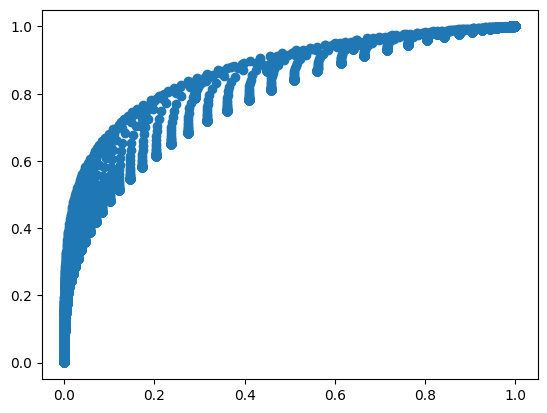

In [22]:
plt.scatter(false_alarm_rate, fault_detection_rate)

In [39]:
pred_fault = faults

In [40]:
np.sum(pred_fault == expected_fault)/len(pred_fault)
# old 0.6798820436507936

0.6798820436507936

In [42]:

fault_nums = test_df["faultNumber"]
for fault_num in np.unique(fault_nums):
    fault_selector = fault_nums==fault_num
    predicted= pred_fault[fault_selector]
    expected= expected_fault[fault_selector]
    TP = np.sum(predicted  &  expected)
    FP = np.sum(predicted  & ~expected)
    FN = np.sum(~predicted &  expected)
    TN = np.sum(~predicted & ~expected)

    fault_detection_rate = TP/(TP+FN)
    false_alarm_rate = FP/(TN+FP)
    false_detection_rate= FP/(TP+FP)
    print(f"Fault: {fault_num}")
    print("Data: ",np.sum(fault_selector))
    print(f"TDR(fault detection rate) {fault_detection_rate}" )
    print(f"FDR(false detection rate) {false_detection_rate}" )
    print(f"FAR(false alarm rate) {false_alarm_rate}" )
    print()

/tmp/ipykernel_540195/1195533928.py:11: RuntimeWarning: invalid value encountered in scalar divide
  fault_detection_rate = TP/(TP+FN)


Fault: 0
Data:  480000
TDR(fault detection rate) nan
FDR(false detection rate) 1.0
FAR(false alarm rate) 0.010441666666666667

Fault: 1
Data:  480000
TDR(fault detection rate) 0.994925
FDR(false detection rate) 0.0012723444514990828
FAR(false alarm rate) 0.0063375

Fault: 2
Data:  480000
TDR(fault detection rate) 0.986905
FDR(false detection rate) 0.0012826707887539878
FAR(false alarm rate) 0.0063375

Fault: 3
Data:  480000
TDR(fault detection rate) 0.01129
FDR(false detection rate) 0.10093569579932311
FAR(false alarm rate) 0.0063375

Fault: 4
Data:  480000
TDR(fault detection rate) 0.720645
FDR(false detection rate) 0.0017557529478988104
FAR(false alarm rate) 0.0063375

Fault: 5
Data:  480000
TDR(fault detection rate) 0.237
FDR(false detection rate) 0.005319651232333407
FAR(false alarm rate) 0.0063375

Fault: 6
Data:  480000
TDR(fault detection rate) 1.0
FDR(false detection rate) 0.0012658954774822913
FAR(false alarm rate) 0.0063375

Fault: 7
Data:  480000
TDR(fault detection rate) 1.